In [1211]:
#Importing the libraries
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
import string
from scipy import sparse
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from xgboost import XGBRFClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import tensorflow as tf

In [1212]:
#Reading the file
df=pd.read_excel("labelled_aud_data (1).xlsx")

In [1213]:
#Displaying the dataset
df.head()

,Car Name,Car URL,Price,Description,cylinders,fuel,odometer,title status,transmission,type,drive,paint color,condition,size,VIN,Clean_Description,Call_Text_Flag,Price_Bins,Extreme_Price_Flag,Probable_Scams
0,2007 volvo xc70,https://chicago.craigslist.org/chc/cto/d/chica...,2998.0,\n\nQR Code Link to This Post\n\n\n2007 volvo ...,5 cylinders,gas,143000.0,clean,automatic,wagon,4wd,silver,excellent,full-size,NaN,qr code link to this post 2007 volvo xc70 stat...,False,"(2000.0, 5000.0]",False,False
1,2006 LEXUS GS 300,https://chicago.craigslist.org/chc/cto/d/chica...,6500.0,\n\nQR Code Link to This Post\n\n\n2006 lexus ...,6 cylinders,gas,124000.0,clean,automatic,sedan,4wd,black,excellent,mid-size,NaN,qr code link to this post 2006 lexus gs300 mil...,False,"(5000.0, 10000.0]",False,False
2,2018 Toyota RAV4 |***Navigation System,https://chicago.craigslist.org/chc/cto/d/chica...,NaN,\n\nQR Code Link to This Post\n\n\nThis 2018 T...,NaN,gas,70698.0,clean,automatic,NaN,NaN,NaN,excellent,NaN,NaN,qr code link to this post this 2018 toyota rav...,False,NaN,False,False
3,2010 Ford Focus,https://chicago.craigslist.org/nch/cto/d/elk-g...,3400.0,\n\nQR Code Link to This Post\n\n\nselling my ...,NaN,gas,145000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,NaN,qr code link to this post selling my 2010 focu...,False,"(2000.0, 5000.0]",False,False
4,2008 Pontiac G6,https://chicago.craigslist.org/nwc/cto/d/itasc...,2500.0,\n\nQR Code Link to This Post\n\n\nhello i hav...,NaN,gas,114000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,NaN,qr code link to this post hello i have a 2008 ...,False,"(2000.0, 5000.0]",False,False


In [1214]:
#Total Scam Distribution
df.Probable_Scams.value_counts()

False    2883
True      117
Name: Probable_Scams, dtype: int64

In [1215]:
#Columns
df.columns

Index(['Car Name', 'Car URL', 'Price', 'Description', 'cylinders', 'fuel',
       'odometer', 'title status', 'transmission', 'type', 'drive',
       'paint color', 'condition', 'size', 'VIN', 'Clean_Description',
       'Call_Text_Flag', 'Price_Bins', 'Extreme_Price_Flag', 'Probable_Scams'],
      dtype='object')

In [1216]:
#Partitioning X and Y
scam_final=df[['Clean_Description','Probable_Scams']]
scam_final.drop_duplicates(inplace=True)
X=scam_final[['Clean_Description']]
y=scam_final[['Probable_Scams']]

#TEXT PREPROCESSING

lemmatizer = nltk.stem.WordNetLemmatizer()

#Tokenizing the description
X['Clean_Description']=X['Clean_Description'].apply(lambda x: nltk.word_tokenize(x)) 

#Lemmatizing the description
X['Clean_Description']=X['Clean_Description'].apply(lambda x :[lemmatizer.lemmatize(item) for item in x if item.isalnum()])

#Removing some common occuring words across the descriptions
X['Clean_Description']=X['Clean_Description'].apply(lambda x:[item for item in x if item not in ['qr','code','link','post','this','to','with']])

#Removing Stop Words
from nltk.corpus import stopwords
stop=stopwords.words('english') #Corpus    
X['stopwords_removed']=X['Clean_Description'].apply(lambda x:[item for item in x if item not in stop if item.isalnum()])
#Joining back the tokens
X['final']=X['stopwords_removed'].apply(lambda x: " ".join(x))

X=X.drop(['Clean_Description','stopwords_removed'],axis=1)

# create text variable
X_text = X['final']

# TF-IDF Vectorization for weighted frequency of words and transform into vector of 1/0
tvf = TfidfVectorizer(stop_words=stopwords.words('english'),min_df=8,ngram_range=(1,2),lowercase=False)
X_text = tvf.fit_transform(X_text)
print(tvf.vocabulary_)

C:\Users\nilch\AppData\Local\Temp\ipykernel_30508\597618497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scam_final.drop_duplicates(inplace=True)
C:\Users\nilch\AppData\Local\Temp\ipykernel_30508\597618497.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Clean_Description']=X['Clean_Description'].apply(lambda x: nltk.word_tokenize(x))
C:\Users\nilch\AppData\Local\Temp\ipykernel_30508\597618497.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

{'2007': 297, 'volvo': 14671, 'station': 13152, 'wagon': 14698, 'clean': 3915, 'run': 12077, 'excellent': 5756, 'automatic': 2314, 'wheel': 14950, 'drive': 5198, 'cylinder': 4666, 'silver': 12773, 'ac': 1634, 'work': 15303, 'perfectly': 10833, 'station wagon': 13155, 'clean run': 3928, 'run excellent': 12079, 'wheel drive': 14962, 'drive cylinder': 5212, 'ac work': 1638, 'work perfectly': 15312, '2006': 291, 'lexus': 8732, 'mile': 9547, 'navigation': 9973, 'system': 13505, 'backup': 2503, 'good': 6670, 'mile clean': 9552, 'navigation system': 9977, '2018': 425, 'toyota': 13916, 'rav4': 11598, 'fuel': 6375, 'efficiency': 5417, 'reliability': 11756, 'open': 10426, 'road': 11958, 'garage': 6440, 'kept': 8383, 'sedan': 12426, 'come': 4078, 'sporty': 13052, 'xle': 15360, 'package': 10562, 'exceptionally': 5767, 'info': 8025, 'contact': 4250, 'set': 12627, 'storage': 13243, 'box': 2884, 'beautiful': 2607, 'great': 6772, 'present': 11207, 'craftsmanship': 4429, 'inch': 7943, 'deep': 4866, 'lo

In [1218]:
#Splitting the Data into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_text.toarray(), y, test_size=0.2,random_state=3)
print(X_test.shape)
print(X_train.shape)

(489, 15456)
(1956, 15456)


In [1175]:
#Scam Distribution for Test Data
y_test.Probable_Scams.value_counts()

False    476
True      13
Name: Probable_Scams, dtype: int64

In [1176]:
#Scam Distribution for Train Data
y_train.Probable_Scams.value_counts()

False    1892
True       64
Name: Probable_Scams, dtype: int64

In [1177]:
summary_statistics={}

In [1222]:

#Random Forest Classifier
clf2 = RandomForestClassifier (n_estimators=300, n_jobs=-1,max_depth=8,max_features=200)
clf2.fit(X_train,y_train)
predict_rf=clf2.predict(X_test)
summary_statistics['random_forest']=roc_auc_score(y_test,predict_rf)

#Extra Tree Classifier
clf4 = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy',max_depth=4)
clf4.fit(X_train,y_train)
predict_extratree=clf4.predict(X_test)
summary_statistics['extra_tree']=roc_auc_score(y_test,predict_extratree)

#Support Vector Classifier
clf5 = SVC()
clf5.fit(X_train,y_train)
predict_svm=clf5.predict(X_test)
summary_statistics['svm']=roc_auc_score(y_test,predict_svm)


#XG Boost RF Classifier
clf10=XGBRFClassifier(learning_rate=0.05,n_estimators=200,max_depth=6)
clf10.fit(X_train,y_train)
predict_xgb=clf10.predict(X_test)
summary_statistics['xgb']=roc_auc_score(y_test,predict_xgb)


#Voting Classifier
predictors=[ ('RF_E', clf2), ('ET_e', clf4),
        ('svc', clf5),("XGB",clf10)]


# building voting
VT=VotingClassifier(predictors)
VT.fit(X_train,y_train)
predicted_VT=VT.predict(X_test)
summary_statistics['VT_classifier']=roc_auc_score(y_test,predicted_VT)

In [1186]:
#Summary Statistics for all the models used
summary_statistics

{'random_forest': 0.5716709760827408,
 'extra_tree': 0.649644473173885,
 'svm': 0.5737718164188752,
 'xgb': 0.6849547511312217,
 'VT_classifier': 0.6101325145442793}

In [1189]:
#Statistics for best model

#Accuracy
from sklearn.metrics import accuracy_score,precision_score,f1_score,RocCurveDisplay,recall_score,roc_auc_score
print("The accuracy score of test data is :",accuracy_score(y_test,predict_xgb))
print("The accuracy score of train data is :",accuracy_score(y_train,clf10.predict(X_train)))
#Precision
print("The precision score of test data is :",precision_score(y_test,predict_xgb))
print("The precision score of train data is :",precision_score(y_train,clf10.predict(X_train)))
#Recall
print("The recall score of test data is :",recall_score(y_test,predict_xgb))
print("The recall score of train data is :",recall_score(y_train,clf10.predict(X_train)))
#ROC AUC SCORE
print("The roc auc score of test data is :",roc_auc_score(y_test,predict_xgb))
print("The roc auc score of train data is :",roc_auc_score(y_train,clf10.predict(X_train)))

The accuracy score of test data is : 0.9693251533742331
The accuracy score of train data is : 0.9856850715746421
The precision score of test data is : 0.4166666666666667
The precision score of train data is : 0.95
The recall score of test data is : 0.38461538461538464
The recall score of train data is : 0.59375
The roc auc score of test data is : 0.6849547511312217
The roc auc score of train data is : 0.7963464587737844


C:\Users\nilch\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


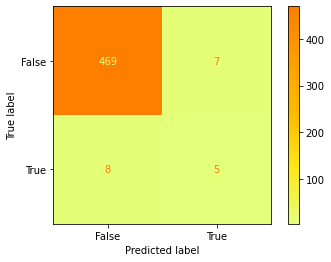

In [1199]:
#Confusion Matrix for XGBOOST- BEST MODEL
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf10, X_test, y_test,cmap='Wistia',colorbar=True)  

In [1201]:
#Exporting the test data with prediction
result=pd.merge(left=pd.DataFrame(predicted,index=y_test.index,columns=['Predicted_Scams']),right=y_test,left_index=True,right_index=True)
pd.merge(left=scam_final['Clean_Description'],right=result,how='inner',left_index=True,right_index=True).to_csv("Topic_data.csv")

In [1219]:
#PRE-PROCESSING FOR RECURRENT LSTM 
x_train, x_test, y_train, y_test = train_test_split(X['final'], scam_label, test_size=0.2, random_state=434)

max_len = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500



tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
total_words = len(word_index)
print(total_words)

#For training set
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = tf.keras.utils.pad_sequences(training_sequences,
                                maxlen=max_len,
                                padding = padding_type,
                                truncating = trunc_type)

#For testing set
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = tf.keras.utils.pad_sequences(testing_sequences,
                               maxlen=max_len,
                               padding = padding_type,
                               truncating = trunc_type)

11730


In [1220]:
#Dimensions of Training and Testing Sensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1956, 500)
Shape of testing tensor:  (489, 500)


In [1221]:
#Compiling and Training the Model
from keras import Sequential
from keras.layers import SpatialDropout1D
# Define parameter 
embedding_dim = 16
drop_value = 0.2
n_dense = 24
n_lstm = 128
drop_lstm = 0.2
# Define LSTM Model 
model1 = Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len))
#model1.add(SpatialDropout1D(drop_lstm))
model1.add(tf.keras.layers.LSTM(n_lstm, return_sequences=False))
#model1.add(tf.keras.layers.Dropout(drop_lstm))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

print(model1.summary())

model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['AUC'])

num_epochs = 30
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=5)
history = model1.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     verbose=2)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 500, 16)           8000      
                                                                 
 lstm_18 (LSTM)              (None, 128)               74240     
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 82,369
Trainable params: 82,369
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
62/62 - 47s - loss: 0.2154 - auc: 0.4612 - val_loss: 0.1445 - val_auc: 0.5392 - 47s/epoch - 762ms/step
Epoch 2/30
62/62 - 42s - loss: 0.1399 - auc: 0.4477 - val_loss: 0.1456 - val_auc: 0.5572 - 42s/epoch - 682ms/step
Epoch 3/30
62/62 - 42s - loss: 0.1389 - auc: 0.5317 - val_loss: 0.1449 - val_auc

In [1154]:
#Predicition using LSTM
def predict_spam(predict_msg):
    new_seq= tokenizer.texts_to_sequences(predict_msg)
    padded = tf.keras.utils.pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
    return (model1.predict(padded))


In [1234]:
y_pred=np.where(model1.predict(testing_padded)>0.5,True,False)

16/16 [==============================] - 1s 83ms/step


In [1235]:
sklearn.metrics.confusion_matrix(y_test,y_pred)

array([[466,   7],
       [ 11,   5]], dtype=int64)